In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv(r'G:\Data Sets\India ML challenge\train.csv')
test_df  = pd.read_csv(r'G:\Data Sets\India ML challenge\test.csv')
sample_sub = pd.read_csv(r'G:\Data Sets\India ML challenge\sample_submission.csv')

In [3]:
train_df['origination_date'] = train_df['origination_date'].astype('datetime64[ns]')
test_df['origination_date'] = test_df['origination_date'].astype('datetime64[ns]')

In [4]:
train_df['year'] = pd.DatetimeIndex(train_df['origination_date']).year
test_df['year'] = pd.DatetimeIndex(test_df['origination_date']).year
train_df['month'] = pd.DatetimeIndex(train_df['origination_date']).month
test_df['month'] = pd.DatetimeIndex(test_df['origination_date']).month
train_df['day'] = pd.DatetimeIndex(train_df['origination_date']).day
test_df['day'] = pd.DatetimeIndex(test_df['origination_date']).day

In [5]:
train = train_df.copy()
test = test_df.copy()

In [6]:
train.drop(['origination_date','first_payment_date'],inplace=True,axis = 1)
test.drop(['origination_date','first_payment_date'],inplace=True,axis = 1)

In [7]:
from sklearn.preprocessing import LabelEncoder

def encode_categorial_features_fit(df, columns_to_encode):
    encoders = {}
    for c in columns_to_encode:
        if c in df.columns:
            encoder = LabelEncoder()
            encoder.fit(df[c].astype(str).values)
            encoders[c] = encoder
    return encoders

def encode_categorial_features_transform(df, encoders):
    out = pd.DataFrame(index=df.index)
    for c in encoders.keys():
        if c in df.columns:
            out[c] = encoders[c].transform(df[c].astype(str).values)
    return out

categorial_features_columns = [
    'source' ,'financial_institution','loan_purpose'
]

categorial_features_encoders = encode_categorial_features_fit(train, categorial_features_columns)
categorial_features_encoders_test = encode_categorial_features_fit(test , categorial_features_columns)

temp = encode_categorial_features_transform(train, categorial_features_encoders)
temp2 = encode_categorial_features_transform(test,categorial_features_encoders_test)

columns_to_drop = list(set(categorial_features_columns) & set(train.columns))
columns_to_drop_2 = list(set(categorial_features_columns) & set(test.columns))

train = train.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
test = test.drop(columns_to_drop_2, axis=1).merge(temp2, how='left', left_index=True, right_index=True)

In [8]:
x_train = train.drop('m13' , axis = 1)
y_train = train['m13']
x_test = test.copy()

In [9]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.feature_selection import RFECV

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split

In [11]:
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
x_train_subset , x_test_subset , y_train_subset , y_test_subset = train_test_split(x_train,y_train,test_size = 0.25 , random_state = 42)

In [13]:
from sklearn.metrics import roc_curve,f1_score,accuracy_score,auc

In [14]:
import lightgbm as lgb

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
from sklearn.metrics import log_loss,auc
def score(params):
    print("Training with params : ")
    print (params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    clf = lgb.LGBMClassifier(**params)
    score = cross_val_score(clf , x_train_subset,y_train_subset , cv = 5).mean()
    print ("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}


In [26]:
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
             'learning_rate' : hp.quniform('eta', 0.025, 0.5, 0.025),
#              'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
#              'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
#              'num_class' : 9,
             'metric': 'binary_logloss',
             'objective': 'binary',
             'nthread' : 4,
#              'silent' : 1
             ' '
             'num_leaves': hp.choice('num_leaves',np.arange(1,100, dtype=int)),
             'min_data_in_leaf' : hp.choice('min_data_in_leaf' , np.arange(100,800, dtype = int)),
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)

    print(best)

In [27]:
trials = Trials()

optimize(trials)

Training with params : 
{' num_leaves': 72, 'colsample_bytree': 0.8, 'learning_rate': 0.35000000000000003, 'metric': 'binary_logloss', 'min_child_weight': 4.0, 'min_data_in_leaf': 646, 'n_estimators': 961.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.9}
	Score 0.9943246425530404


Training with params : 
{' num_leaves': 24, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.35000000000000003, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 723, 'n_estimators': 834.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.9944165523379134


Training with params : 
{' num_leaves': 91, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 101, 'n_estimators': 831.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.5}
	Score 0.9957262573681464


Training with params : 
{' num_leaves': 38, 'colsample_bytree': 0.9, 'learning_rate': 0.3000000000

	Score 0.9941867821653692


Training with params : 
{' num_leaves': 37, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.45, 'metric': 'binary_logloss', 'min_child_weight': 6.0, 'min_data_in_leaf': 442, 'n_estimators': 386.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.9}
	Score 0.9942557126891769


Training with params : 
{' num_leaves': 29, 'colsample_bytree': 0.75, 'learning_rate': 0.4, 'metric': 'binary_logloss', 'min_child_weight': 5.0, 'min_data_in_leaf': 708, 'n_estimators': 318.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.8}
	Score 0.9944165523379134


Training with params : 
{' num_leaves': 98, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'metric': 'binary_logloss', 'min_child_weight': 6.0, 'min_data_in_leaf': 413, 'n_estimators': 435.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.9}
	Score 0.9945199510933748


Training with params : 
{' num_leaves': 45, 'colsample_bytree': 0.8500000000000001, 'learning_rate'

	Score 0.9943820867460372


Training with params : 
{' num_leaves': 68, 'colsample_bytree': 0.65, 'learning_rate': 0.42500000000000004, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 104, 'n_estimators': 972.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.9956573222247282


Training with params : 
{' num_leaves': 86, 'colsample_bytree': 0.55, 'learning_rate': 0.025, 'metric': 'binary_logloss', 'min_child_weight': 1.0, 'min_data_in_leaf': 189, 'n_estimators': 218.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.5}
	Score 0.9959330482796256


Training with params : 
{' num_leaves': 62, 'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 661, 'n_estimators': 254.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.65}
	Score 0.9945659049958946


Training with params : 
{' num_leaves': 11, 'colsample_bytree': 0.5, 'learning_rate': 0.225, '

	Score 0.9941982665163472


Training with params : 
{' num_leaves': 99, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.5, 'metric': 'binary_logloss', 'min_child_weight': 4.0, 'min_data_in_leaf': 347, 'n_estimators': 559.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.9941063659706947


Training with params : 
{' num_leaves': 22, 'colsample_bytree': 0.9, 'learning_rate': 0.47500000000000003, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 760, 'n_estimators': 732.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.75}
	Score 0.994370597775449


Training with params : 
{' num_leaves': 74, 'colsample_bytree': 0.8, 'learning_rate': 0.375, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 521, 'n_estimators': 814.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.7000000000000001}
	Score 0.9943935750566812


Training with params : 
{' num_leaves': 97, 'colsample_bytree': 1.0, 'learning_rate'

	Score 0.9945659049958946


Training with params : 
{' num_leaves': 91, 'colsample_bytree': 0.8, 'learning_rate': 0.125, 'metric': 'binary_logloss', 'min_child_weight': 4.0, 'min_data_in_leaf': 314, 'n_estimators': 924.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.65}
	Score 0.9947497285253064


Training with params : 
{' num_leaves': 24, 'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'metric': 'binary_logloss', 'min_child_weight': 1.0, 'min_data_in_leaf': 793, 'n_estimators': 797.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.7000000000000001}
	Score 0.9945659049958946


Training with params : 
{' num_leaves': 73, 'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.325, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 440, 'n_estimators': 860.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.8}
	Score 0.9943476231339942


Training with params : 
{' num_leaves': 23, 'colsample_bytree': 0.8, 'learning_rate': 0.4750000

	Score 0.994129339292261


Training with params : 
{' num_leaves': 4, 'colsample_bytree': 0.8, 'learning_rate': 0.45, 'metric': 'binary_logloss', 'min_child_weight': 4.0, 'min_data_in_leaf': 555, 'n_estimators': 553.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.75}
	Score 0.9941523159135487


Training with params : 
{' num_leaves': 59, 'colsample_bytree': 1.0, 'learning_rate': 0.5, 'metric': 'binary_logloss', 'min_child_weight': 5.0, 'min_data_in_leaf': 331, 'n_estimators': 723.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.5}
	Score 0.9941982704760131


Training with params : 
{' num_leaves': 78, 'colsample_bytree': 0.9, 'learning_rate': 0.42500000000000004, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 293, 'n_estimators': 769.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.9952782013740358


Training with params : 
{' num_leaves': 95, 'colsample_bytree': 0.9, 'learning_rate': 0.325, 'metric': 'binary_loglo

	Score 0.9944165536578019


Training with params : 
{' num_leaves': 6, 'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.45, 'metric': 'binary_logloss', 'min_child_weight': 1.0, 'min_data_in_leaf': 347, 'n_estimators': 788.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.9942212477572452


Training with params : 
{' num_leaves': 25, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 207, 'n_estimators': 649.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.8}
	Score 0.9955883930208091


Training with params : 
{' num_leaves': 68, 'colsample_bytree': 0.9, 'learning_rate': 0.45, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 290, 'n_estimators': 574.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.55}
	Score 0.9951633123280977


Training with params : 
{' num_leaves': 69, 'colsample_bytree': 0.75, 'learning_rate': 0.42500000000

	Score 0.9942327373877777


Training with params : 
{' num_leaves': 80, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'metric': 'binary_logloss', 'min_child_weight': 2.0, 'min_data_in_leaf': 248, 'n_estimators': 726.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.5}
	Score 0.9953930864603079


Training with params : 
{' num_leaves': 53, 'colsample_bytree': 0.65, 'learning_rate': 0.2, 'metric': 'binary_logloss', 'min_child_weight': 3.0, 'min_data_in_leaf': 218, 'n_estimators': 941.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.75}
	Score 0.9958526281252851


Training with params : 
{' num_leaves': 41, 'colsample_bytree': 0.9, 'learning_rate': 0.47500000000000003, 'metric': 'binary_logloss', 'min_child_weight': 4.0, 'min_data_in_leaf': 704, 'n_estimators': 199.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.8500000000000001}
	Score 0.9942672036395981


Training with params : 
{' num_leaves': 96, 'colsample_bytree': 0.8500000000000001, 'learning_rate'

	Score 0.9958756067264058


Training with params : 
{' num_leaves': 99, 'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.47500000000000003, 'metric': 'binary_logloss', 'min_child_weight': 5.0, 'min_data_in_leaf': 313, 'n_estimators': 805.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.6000000000000001}
	Score 0.994473999830632


Training with params : 
{' num_leaves': 29, 'colsample_bytree': 0.9, 'learning_rate': 0.25, 'metric': 'binary_logloss', 'min_child_weight': 6.0, 'min_data_in_leaf': 142, 'n_estimators': 732.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.75}
	Score 0.9958641157759848


Training with params : 
{' num_leaves': 23, 'colsample_bytree': 1.0, 'learning_rate': 0.225, 'metric': 'binary_logloss', 'min_child_weight': 1.0, 'min_data_in_leaf': 194, 'n_estimators': 395.0, 'nthread': 4, 'objective': 'binary', 'subsample': 0.8}
	Score 0.9955883923608647


Training with params : 
{' num_leaves': 2, 'colsample_bytree': 0.55, 'learning_rate': 0.5, 'metric

In [28]:
LG1 = lgb.LGBMClassifier(colsample_bytree=0.8500000000000001 , eta = 0.07500000000000001 , eval_metric = 'binary_logloss' , min_child_weight = 2.0 , n_estimators=459 , objective='binary' , 
                      subsample= 0.75 , num_leaves = 28 , min_data_in_leaf = 249)

In [29]:
LG1.fit(x_train_subset,y_train_subset)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.8500000000000001, eta=0.07500000000000001,
        eval_metric='binary_logloss', importance_type='split',
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=2.0, min_data_in_leaf=249, min_split_gain=0.0,
        n_estimators=459, n_jobs=-1, num_leaves=28, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=0.75, subsample_for_bin=200000, subsample_freq=0)

the AUC is : 0.8359


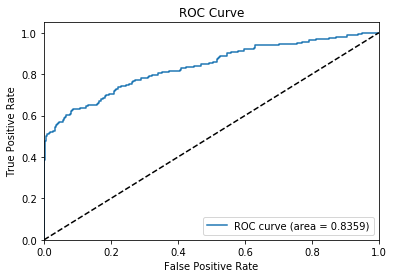

In [30]:
Performance(Model=LG1 , Y = y_test_subset , X = x_test_subset)

In [31]:
final_pred = LG1.predict(x_test)

In [32]:
sample_sub['m13'] = final_pred
sample_sub.to_csv('12th_soln.csv' , index = False)